# Quickstart Example

Let’s consider a simple regression problem on diabetes data provided by Scikit-learn. We want to evaluate the uncertainty associated with the prediction using inductive (or split) conformal prediction.

## Data 
By construction, data are indepent and identically distributed (i.i.d) (for
more information, check the official
[documentation](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html).
Great: we fullfill the exchangeability condition to apply conformal prediction!
The next step is spliting the data into three subsets:

* Fit subset ${\cal D_{fit}}$ to train the model.
* Calibration subset ${\cal D_{calib}}$ on which nonconformity scores are
  computed.
* Test subset ${\cal D_{test}}$ on which the prediction intervals are
  estimated.

---
**NOTE**

   Rigorously, for the probabilistic guarantee to hold, the calibration subset
   needs to be sampled for each new example in the test set.

---


The following code implements all the aforementioned steps:

In [1]:
import numpy as np
from sklearn import datasets

random_seed = 42
np.random.seed(random_seed)

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
X_train = diabetes_X[:-100]
X_test = diabetes_X[-100:]

# Split the targets into training/testing sets
y_train = diabetes_y[:-100]
y_test = diabetes_y[-100:]

# Split fit and calibration data
X_fit, X_calib = X_train[:-100], X_train[-100:]
y_fit, y_calib = y_train[:-100], y_train[-100:]

## Prediction Model

We consider a simple linear regression model from
[scikit-learn regression module](https://scikit-learn.org/stable/modules/linear_model.html),
to be trained later on ${\cal D_{fit}}$:

In [2]:
from sklearn import linear_model

# Create linear regression model
lin_reg_model = linear_model.LinearRegression()

Such model needs to be wrapped in a wrapper provided in the module deel.puncc.api.prediction. The wrapper makes it possible to use various models from different ML/DL libraries such as Scikit-learn, Keras or XGBoost. For more information about model wrappers and supported ML/DL libraries, we refere the user to the documentation.

For a linear regression from scikit-learn, we use deel.puncc.api.prediction.BasePredictor as follows:

In [3]:
from deel.puncc.api.prediction import BasePredictor

# Create a predictor to wrap the linear regression model defined earlier
# The argument `is_trained` is set to False such that the linear model needs to be
# trained before the calibration. You can initialize it to True if the model is
# already trained and you want to save time.
lin_reg_predictor =  BasePredictor(lin_reg_model, is_trained=False)

## Split Conformal Regression

For this example, the prediction intervals are obtained throught the split
conformal prediction method provided by the class
`deel.puncc.regression.SplitCP`. Other methods are presented
in the documentation.

In [4]:
from deel.puncc.regression import SplitCP

# Coverage target is 1-alpha = 90%
alpha=.1

# Instanciate the split cp wrapper around the linear predictor.
split_cp = SplitCP(lin_reg_predictor)

# Train model (if argument `is_train` is False) on the fitting dataset and
# compute the residuals on the calibration dataset.
split_cp.fit(X_fit, y_fit, X_calib, y_calib)

# The `predict` returns the output of the linear model `y_pred` and
# the calibrated interval [`y_pred_lower`, `y_pred_upper`].
y_pred, y_pred_lower, y_pred_upper = split_cp.predict(X_test, alpha=alpha)

The library provides several metrics in deel.puncc.metrics to evaluate the conformalization procedure. Below, we compute the average empirical coverage and the average empirical width of the prediction intervals on the test examples:

In [5]:
from deel.puncc import metrics

coverage = metrics.regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = metrics.regression_sharpness(y_pred_lower=y_pred_lower,
                                    y_pred_upper=y_pred_upper)
print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average width: {np.round(width, 2)}")

Marginal coverage: 0.95
Average width: 211.38


In addition, puncc provides plotting tools in deel.puncc.plotting to visualize the prediction intervals and whether or not the observations are covered:

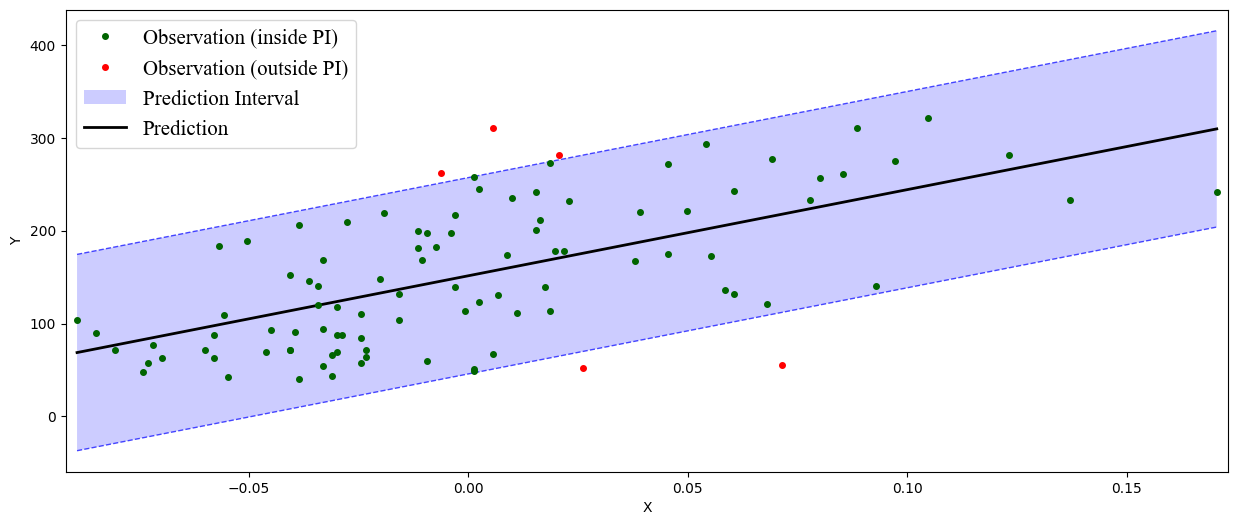

In [6]:
from deel.puncc.plotting import plot_prediction_intervals

# Figure of the prediction bands

ax = plot_prediction_intervals(
        X = X_test[:,0],
        y_true=y_test,
        y_pred=y_pred,
        y_pred_lower=y_pred_lower,
        y_pred_upper=y_pred_upper,
        loc="upper left")

### Low-level API

We now define the **same split conformal prediction** procedure using the low-level API. Also, we showcase how flexible such approach is by tweaking some of its components.

#### Calibrator

The calibrator instance provides a way of estimating the nonconformity scores on the calibration set and how to compute the prediction sets. For the split conformal prediction procedure, the `BaseCalibrator` uses the mean absolute deviation as nonconformity score and and prediction set are built as constant intervals. These two functions are already provided in `deel.puncc.api.nonconformity_scores.mad` and `deel.puncc.api.prediction_sets.constant_interval`, respectively. Alternatively, one can define custom functions and pass them as arguments to the calibrator. 

In [7]:
from deel.puncc.api.calibration import BaseCalibrator
from deel.puncc.api import nonconformity_scores
from deel.puncc.api import prediction_sets

## Calibrator construction
my_calibrator = BaseCalibrator(nonconf_score_func=nonconformity_scores.mad,
                               pred_set_func=prediction_sets.constant_interval)

The `BaseCalibrator` below is similar to the previous one, except it integrates custom nonconformity score (`my_ncf`) and prediction set (`my_psf`) functions:

In [8]:
## Definition of a custom nonconformity scores function.
## Alternatively, several ready-to-use nonconf scores are provided in
## the module deel.puncc.nonconformity_scores
def my_ncf(y_pred, y_true):
    return np.abs(y_pred-y_true)

## Definition of a custom function to build prediction sets.
## Alternatively, several ready-to-use procedure are provided in
## the module deel.puncc.prediction_sets
def my_psf(y_pred, scores_quantile):
    y_lower = y_pred - scores_quantile
    y_upper = y_pred + scores_quantile
    return y_lower, y_upper

## Calibrator construction
my_calibrator = BaseCalibrator(nonconf_score_func=my_ncf,
                               pred_set_func=my_psf)

#### Splitter

In **split conformal prediction**, we can either use a deterministic or a random procedure to split the data into fit and calibration.
As we already separated the two subsets, we use the IdSplitter that wraps the data and produces iterables accordingly to **puncc**'s framework: 

In [9]:
from deel.puncc.api.splitting import IdSplitter

# Wrapper predetermined data schemes in the id splitter 
id_splitter = IdSplitter(X_fit, y_fit, X_calib, y_calib)

#### Conformalization

The split **conformal predictor** assembles the previously defined **predictor**, **calibrator** and **splitter** in a specific process to provide prediction intervals with a guaranteed coverage rate: 

In [10]:
from deel.puncc.api.conformalization import ConformalPredictor
from deel.puncc.api.splitting import IdSplitter

# Wrapper predetermined data schemes in the id splitter 
id_splitter = IdSplitter(X_fit, y_fit, X_calib, y_calib)
# Instanciate a conformal prediction object
split_cp = ConformalPredictor(predictor=lin_reg_predictor, 
                              calibrator=my_calibrator, 
                              splitter=id_splitter,
                              train=True)
# Fit model and compute nonconformity scores
split_cp.fit(X_train, y_train)
# infer prediction interval w.r.t the level risk alpha
y_pred, y_pred_lower, y_pred_upper = split_cp.predict(X_test, alpha=alpha)

Marginal coverage: 0.95
Average width: 211.38


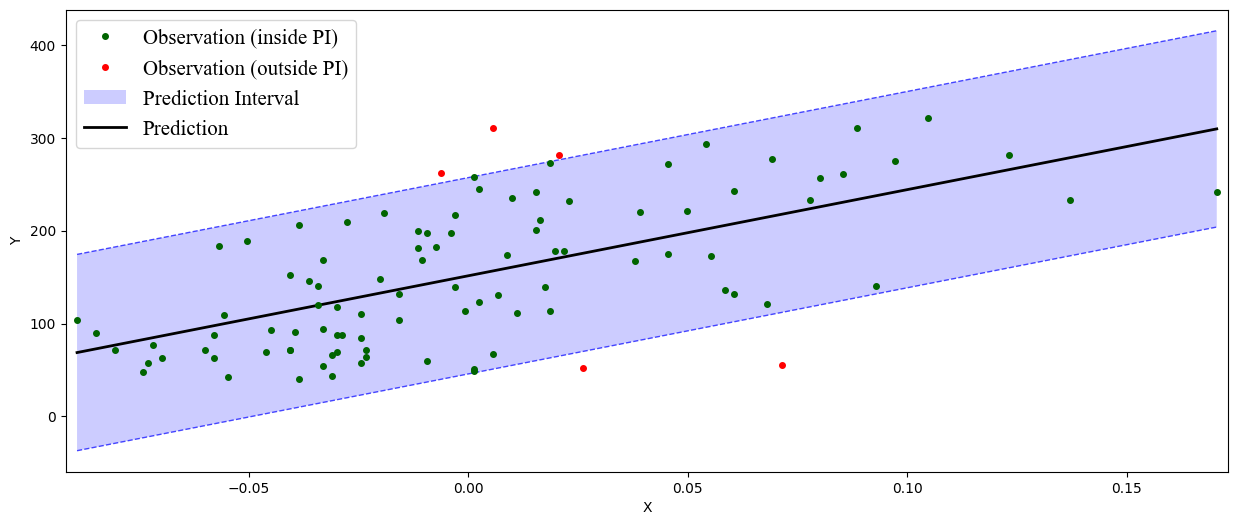

In [11]:
coverage = metrics.regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = metrics.regression_sharpness(y_pred_lower=y_pred_lower,
                                    y_pred_upper=y_pred_upper)

print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average width: {np.round(width, 2)}")

# Figure of the prediction bands
ax = plot_prediction_intervals(
        X = X_test[:,0],
        y_true=y_test,
        y_pred=y_pred,
        y_pred_lower=y_pred_lower,
        y_pred_upper=y_pred_upper,
        loc="upper left")

As such, we obtain the same results as in the high-level API. Notice that we have a conservative prediction interval, because the obtained empirical coverage is larger than the target.

Now let's try to have a tighter enveloppe by modifying the split plan into a K-fold. This is simply done by changing the splitter argument in the `ConformalPredictor` constructor:

In [12]:
from deel.puncc.api.splitting import KFoldSplitter

# 20-fold data splitter
kfold_splitter = KFoldSplitter(K=20, random_state=random_seed)

# Only the splitter argument is changed from before
cv_cp = ConformalPredictor(predictor=lin_reg_predictor, 
                           calibrator=my_calibrator, 
                           splitter=kfold_splitter,
                           train=True)

cv_cp.fit(X_train, y_train)

y_pred, y_pred_lower, y_pred_upper = cv_cp.predict(X_test, alpha=alpha)

Marginal coverage: 0.95
Average width: 208.97


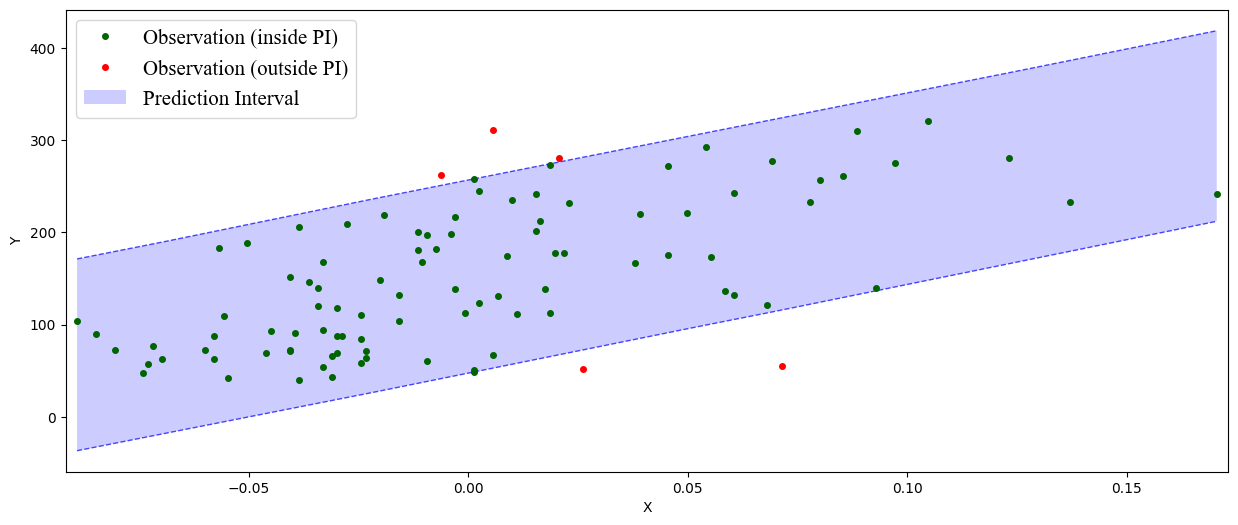

In [13]:
# Compute marginal coverage and average width of the prediction intervals
coverage = metrics.regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = metrics.regression_sharpness(y_pred_lower=y_pred_lower,
                                    y_pred_upper=y_pred_upper)

print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average width: {np.round(width, 2)}")

# Figure of the prediction bands
ax = plot_prediction_intervals(
        X = X_test[:,0],
        y_true=y_test,
        y_pred=y_pred,
        y_pred_lower=y_pred_lower,
        y_pred_upper=y_pred_upper,
        loc="upper left")

Now, let's use a state of the art method called EnbPI. This method is specifically tailored for time series (data are not exchangeable).

In [14]:
from deel.puncc.regression import EnbPI
from sklearn.ensemble import RandomForestRegressor

# Predictor
mu_rf = RandomForestRegressor(n_estimators=100, n_jobs=4, random_state=random_seed)
rf_predictor = BasePredictor(mu_rf)

# Enbpi conformalizer
enbpi = EnbPI(rf_predictor, B=30, agg_func_loo=np.mean)

# Fit and interval prediction
enbpi.fit(X_train, y_train)
y_pred, y_pred_lower, y_pred_upper = enbpi.predict(X_test, alpha=alpha, y_true=y_test, s=None)

100%|██████████| 342/342 [00:00<00:00, 9017.12it/s]


 === step 1/2: fitting bootstrap estimators ...


100%|██████████| 30/30 [00:04<00:00,  7.41it/s]


 === step 2/2: computing nonconformity scores ...


Marginal coverage: 0.91
Average width: 225.56


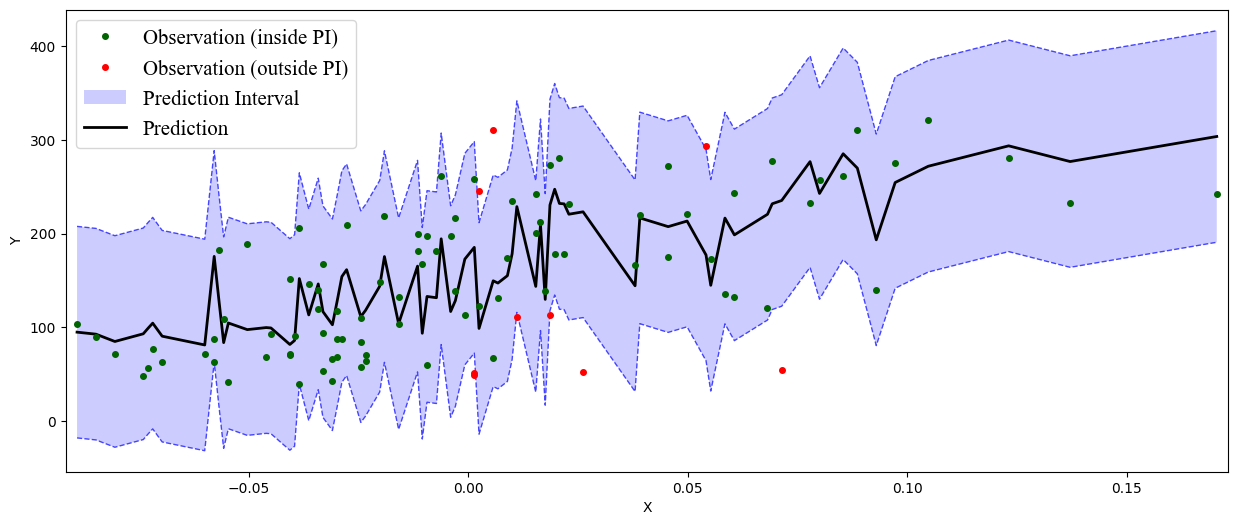

In [15]:
# Compute marginal coverage and average width of the prediction intervals
coverage = metrics.regression_mean_coverage(y_test, y_pred_lower, y_pred_upper)
width = metrics.regression_sharpness(y_pred_lower=y_pred_lower,
                                    y_pred_upper=y_pred_upper)

print(f"Marginal coverage: {np.round(coverage, 2)}")
print(f"Average width: {np.round(width, 2)}")

# Figure of the prediction bands
ax = plot_prediction_intervals(
        X = X_test[:,0],
        y_true=y_test,
        y_pred=y_pred,
        y_pred_lower=y_pred_lower,
        y_pred_upper=y_pred_upper,
        loc="upper left")